This notebook should be run on Google Colab.
<a href="https://colab.research.google.com/github/SavvinaDaniil/UnfairnessOfPopularityBias/blob/main/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Process
In this notebook, we will train all the algorithms on MovieLens1M using <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

## A. Import lbraries

In [1]:
# # for dependency reasons with Cornac
# #!pip uninstall tensorflow -y
# !pip install tensorflow-gpu==1.15
# #!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0

In [2]:
!pip install cornac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, ItemKNN, UserKNN, BaselineOnly 
from cornac.models import NMF as CornacNMF 
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [3]:
# constants and initialization
rating_threshold = 1.0 # needed for the cornac library: Threshold used to binarize rating values into positive or negative feedback for model evaluation using ranking metrics (rating metrics are not affected). 
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
user_col = "user"
top_fraction = 0.2 # the amount of items that will be considered "popular"

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

## C. Read files

In [4]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/ratings_movies.dat'

# read user events
cols = ['user', 'movie', 'rating', 'timestamp']
df_events = pd.read_table(user_events_file, sep = "::", engine="python", names=cols)
item_col = "movie"
print('No. of user events: ' + str(len(df_events)))

No. of user events: 1000209


In [5]:
df_events.head()

,user,movie,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## D. Data analysis

In [6]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [7]:
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 1000209
No. items: 3706
No. users: 6040


Mean movies per user: 165.6
Min movies per user: 20
Max movies per user: 2314


Mean users per movie: 269.9
Min users per movie: 1
Max users per movie: 3428




In [8]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item


In [9]:
df_item_dist.head()

,count
2858,0.56754967
260,0.49519868
1196,0.49503311
1210,0.47731788
480,0.44238411


In [10]:
def plot_data_distribution(item_dist, item_col,log = False):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = " (log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    plt.show(block=True)

def plot_popularity_distribution(pop_fraq, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

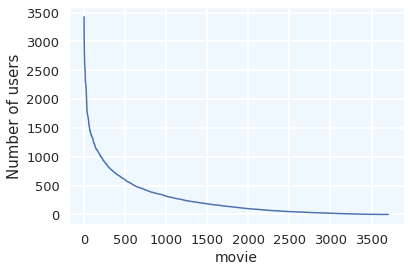

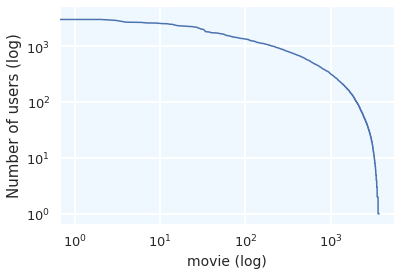

In [11]:
plot_data_distribution(item_dist, item_col)
plot_data_distribution(item_dist, item_col, True)

## E. Popularity in the data

In [12]:
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. items labeled as "popular": ' + str(len(top_item_dist)))

No. items labeled as "popular": 741


In [13]:
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [14]:
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col)

1000
2000
3000
4000
5000
6000


In [15]:
def plot_popularity_distribution(pop_fraq, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

def plot_profile_size_vs_popularity(pop_metric, user_hist, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_metric)
    print('R-value: ' + str(r_value))
    line = slope * np.array(user_hist) + intercept
    plt.plot(user_hist, pop_metric, 'o', user_hist, line)
    plt.xlabel('User profile size', fontsize='15')
    plt.xticks(fontsize='13')
    if way == "count":
        ylabel = "Number of popular "+item_col+"s"
    elif way == "percentage":
        ylabel = 'Percentage of popular '+item_col+'s'
    else:
        ylabel = "Average popularity of "+item_col+"s"
    plt.ylabel(ylabel, fontsize='15')
    plt.yticks(fontsize='13')
    plt.show(block=True)

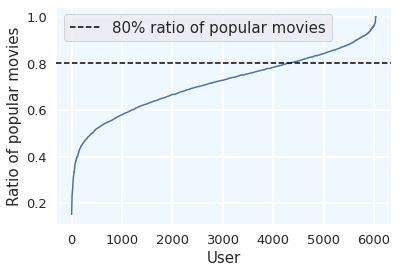

R-value: 0.9662364112421091


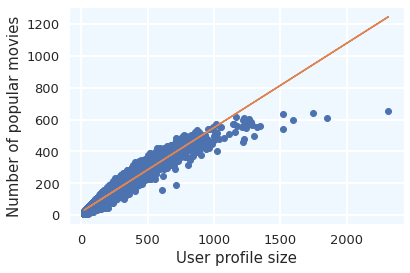

R-value: -0.40259977494843086


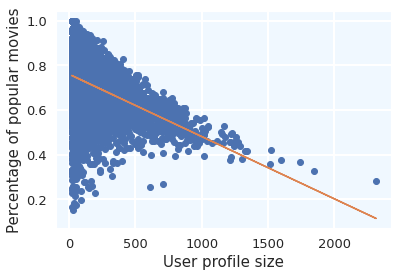

R-value: -0.48167705404310895


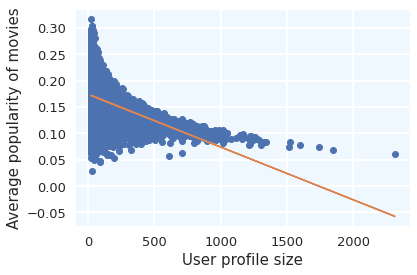

In [16]:
plot_popularity_distribution(pop_fraq, item_col)
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col)
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col)
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col)

## F. User groups

In [17]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

### Make notion of popularity propensity choice
The reader has to manually choose how to divide the users into groups according to their propensity for popular items.

In [18]:
popularity_function = {'pop_one': "pop_fraq", # divide by percentage of popular items in profile
             'pop_two': "pop_item_fraq"} # divide by average popularity in profile

In [19]:
pop_notion = "pop_one"

In [20]:
user_dist_sorted = sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = popularity_function[pop_notion])
low, med, high = split(user_dist_sorted, top_fraction)
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)

In [21]:
print('Niche GAP: ' + str(low_GAP))
print('Diverse GAP: ' + str(med_GAP))
print('Blockbuster-focused GAP: ' + str(high_GAP))

Niche GAP: 0.1080159187333548
Diverse GAP: 0.1569755573676999
Blockbuster-focused GAP: 0.20907251963505036


In [22]:
def plot_group_characteristics(low_nr, med_nr, high_nr, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.bar(np.arange(3), [low_nr, med_nr, high_nr])
    plt.xticks(np.arange(3), ['Niche', 'Diverse', 'Blockbuster-focused'])
    plt.xlabel('User group')
    if way=="size":
        ylabel = 'Average user profile size'
    else:
        ylabel = "Number of users per group"
    plt.ylabel(ylabel)
    
    print('Niche: ' + str(low_nr))
    print('Diverse: ' + str(med_nr))
    print('Blockbuster-focused: ' + str(high_nr))
    plt.show(block=True)

Niche: 1208
Diverse: 3624
Blockbuster-focused: 1208


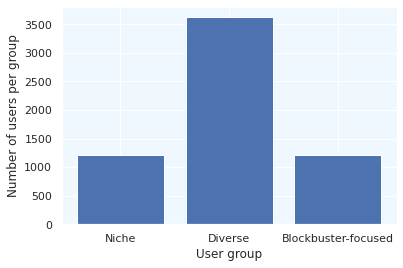

Niche: 301.737582781457
Diverse: 152.3543046357616
Blockbuster-focused: 69.18708609271523


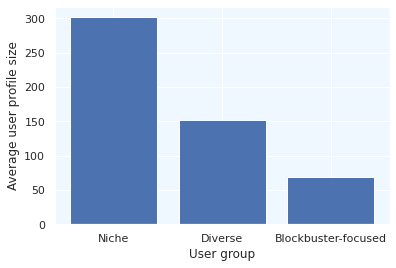

In [23]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number", item_col = item_col)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col)

## G. Recommendation

In [24]:
df_events.head()

,user,movie,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### G.1 Cornac

In [25]:
df_events_cornac = df_events.copy()
mapping_dict = {} # Create a dictionary that maps each movie number to an integer - necessary for Cornac.
i=0
for mov in df_events_cornac[item_col].unique():
    mapping_dict[mov] = i
    i+=1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [26]:
df_events_cornac.user = df_events_cornac.user.astype("string")
df_events_cornac.movie = df_events_cornac.movie.astype("string")

In [27]:
df_item_dist_cornac = df_item_dist.rename(index = mapping_dict)

In [28]:
data = list(df_events_cornac[[user_col,item_col,predict_col]].to_records(index = False)) # ready to import in Cornac.

In [29]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=123)

In [30]:
all_items = set(range(rs.total_items)) # needed for later

In [31]:
# Define the two different options for UserKNN, with and without mean centering
usKNN = UserKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True)
usKNN_means = UserKNN(k=40, similarity = 'cosine', mean_centered=True, seed = my_seed, verbose=True)

#### Training

Google Colab no longer supports Tensorflow v1, which creates dependency issues with Cornac which is built on Tensorflow v1. Until we find a solution, we will exclude the models that do not run for this reason.

In [32]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          usKNN,
          # 4: ItemKNN
          ItemKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True),
          # 5: UserKNN with means
          usKNN_means,
          # 7: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123, verbose=True),
          # 8: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123, verbose=True),
          # 9: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, verbose=True),
          # 10: NMF
          CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 11: WMF
          #WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 12: PF
          #HPF(k=50, seed=123, hierarchical=False, name="PF", verbose=True),
          # 13: NueMF
          #NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 14: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [39]:
algo_names = ["Random",
              "MostPop", 
              "UserKNN",
              "ItemKNN", 
              "UserKNN with means", 
              "BPR",
              "MF",
              "PMF",
              "NMF",
              #"WMF",
              #"HPF",
              #"NeuMF",
              "VAECF"
              ] # in the order that they are in the model list

In [4]:
# define metrics to evaluate the models
metrics = [MAE()]

# put it together in an experiment, voilà!
start = time.time()
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()
end = time.time()
print(round(end-start), "seconds.")

#### Ranking and recommendation
We have identified three evaluation strategies:
1. For every user in the **train set** rank **all items**. | Book paper, *eva_one*
2. For every user in the **test set** rank **only the items this user has rated in the test set**. | Music paper, *eva_two*
3. For every user in the **test set** rank **only the items this user has NOT rated in the train set**. | Movie(?) paper, *eva_three*

For every evaluation strategy, we define a function that recommends the appropriate items to the appropriate users as described above. 

##### Functions

In [ ]:
def get_top_n_eva_one(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(model.train_set.uid_map.values()): # every user in the train set
    user_id = list(model.train_set.user_ids)[uid]
    item_rank = model.rank(user_idx=uid)[0] # all
    # collect top N items
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [ ]:
def get_top_n_eva_two(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_test_set = rs.test_set.user_data[uid][0] 
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_in_the_test_set)[0] # items the user has rated in the test set 
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [ ]:
def get_top_n_eva_three(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)

  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
    user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set))
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_not_in_the_train_set)[0] # items the user has NOT rated in the TRAIN set
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [ ]:
# random recommendation algorithm, same for every strategy 
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)

    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
        user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set)) # random choice out of the items that the user has NOT rated in the train set
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(user_items_not_in_the_train_set)), i))
          
    return top_n

##### Recommendation

Choose evaluation strategy.

In [ ]:
evaluation_function = {'eva_one':get_top_n_eva_one,
             'eva_two': get_top_n_eva_two,
             'eva_three': get_top_n_eva_three}

In [ ]:
choice = 'eva_three'
# to be manually set!!! 

### Prediction
Run it when different evaluation strategy is chosen.

In [ ]:
algo_dict = {}
for i in range(0, len(algo_names)):
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    else:
      top_n = evaluation_function[choice](algo_names[i],i-1, n=10)
    algo_dict[algo_names[i]] = top_n.items()

### Evaluation
Run it when different popularity notion is chosen.

In [ ]:
start = time.time()
i = 0
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    
    df_item_dist_cornac[algo_names[i]] = 0
    
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    low_count = 0
    med_count = 0
    high_count = 0

    top = algo_dict[algo_names[i]]
    for uid, user_ratings in tqdm(top):
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist_cornac.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(df_item_dist_cornac["count"].loc[iid_list]) / len(iid_list)
        if uid in low.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in med.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high.index:
            high_rec_gap += gap
            high_count += 1
        else:
          print("hi")
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm
end = time.time()
print(round(end-start), "seconds.")

Random model is selected:


100%|██████████| 3815/3815 [00:11<00:00, 322.67it/s]


MostPop model is selected:


100%|██████████| 6038/6038 [00:21<00:00, 287.07it/s]


UserKNN model is selected:


100%|██████████| 6038/6038 [00:18<00:00, 321.57it/s]


ItemKNN model is selected:


100%|██████████| 6038/6038 [00:21<00:00, 279.01it/s]


UserKNN with means model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 307.44it/s]


BPR model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 302.57it/s]


MF model is selected:


100%|██████████| 6038/6038 [00:22<00:00, 274.21it/s]


PMF model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 303.60it/s]


NMF model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 303.71it/s]


WMF model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 307.64it/s]


HPF model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 307.08it/s]


NeuMF model is selected:


100%|██████████| 6038/6038 [00:20<00:00, 295.21it/s]


VAECF model is selected:


100%|██████████| 6038/6038 [00:19<00:00, 306.48it/s]


### Cornac results.

In [ ]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_GAP) / high_GAP * 100)

# Save!!
The files will be saved in your drive.

In [ ]:
from google.colab import files
import pickle as pkl

In [ ]:
df_item_dist_cornac.to_csv('df_item_dist_cornac_movies_'+choice+'.csv') 
files.download('df_item_dist_cornac_movies_'+choice+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('low_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(low_gap_vals, handle)
files.download('low_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('med_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(medium_gap_vals, handle)
files.download('med_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('high_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(high_gap_vals, handle)
files.download('high_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>